In [178]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [179]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [
        ([2], lambda df: isin_filter(df, 'ovar_histtype', [2])), 
        ([2, 4, 6, 8, 9, 31], lambda df: isin_filter(df, 'ovar_histtype', [2, 4, 6, 8, 9, 31]))
    ]
}


In [180]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperScreenedOrCancer,
    ExperimentDataHelperScreened,
    ExperimentDataHelperNotScreenedCols,
    ExperimentDataHelperScreenedCols,
    ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll
]

In [181]:
experiment_names = []
years = [1]
num_folds=10
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            experiment_names.append(filesuffix)

In [182]:
experiment_names

['experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials']

In [183]:
def load_cv_analytics_util_see_stats(filesuffix):
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    return cv_analytics_util

In [184]:
filesuffix = 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)

In [186]:
threshold = 0.1611

In [188]:
id_col = 'index'

In [189]:
all_mid_confidence_ids = []
all_high_confidence_ids = []
all_positive_ids = []
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch = analytics_util.data_util.test_df.copy()[[id_col, 'plco_id', 'age', label]]
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    # X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)
X_test_mismatch = mid_conf_predictions
# Mid confidence
X_test_mid_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > threshold) & (X_test_mismatch[f'{label}_prob'] < 1 - threshold)]
mid_conf_ids = X_test_mid_conf[id_col].to_list()
all_mid_confidence_ids.extend(mid_conf_ids)
mid_conf_predictions = X_test_mid_conf
# High Conf
X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] <= threshold) | (X_test_mismatch[f'{label}_prob'] >= 1 - threshold)]
high_conf_ids = X_test_high_conf[id_col].to_list()
all_high_confidence_ids.extend(high_conf_ids)
# Positive Ids
X_test_positive = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > 0.5)]
positive_ids = X_test_positive[id_col].to_list()
all_positive_ids.extend(positive_ids)

In [190]:
mid_range_filter = lambda df: isin_filter(df, id_col, all_mid_confidence_ids)
high_range_filter = lambda df: isin_filter(df, id_col, all_high_confidence_ids)
positive_range_filter = lambda df: isin_filter(df, id_col, all_positive_ids)

In [191]:
def set_filter_display_report(cv_analytics_util, filter):
    cv_analytics_util.set_filter(filter)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

In [192]:
cv_analytics_util.update_thresholds(threshold)

The chance of getting cancer in the next year for the whole population is 0.0009



Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.99976    | 3.71609e-05 | 0.999674   | 0.999805   |
| recall__class_0    | 0.631848   | 0.0122642   | 0.613177   | 0.648685   |
| f1-score__class_0  | 0.774261   | 0.0092086   | 0.760146   | 0.78684    |
| precision__class_1 | 0.00211864 | 0.000331101 | 0.00163992 | 0.00269623 |
| recall__class_1    | 0.835802   | 0.0247775   | 0.807692   | 0.878788   |
| f1-score__class_1  | 0.00422636 | 0.000658944 | 0.00327332 | 0.00537474 |
| accuracy           | 0.632038   | 0.0122595   | 0.613339   | 0.648881   |
| auc                | 0.82516    | 0.016402    | 0.793601   | 0.842297   |
+--------------------+------------+-------------+------------+------------+


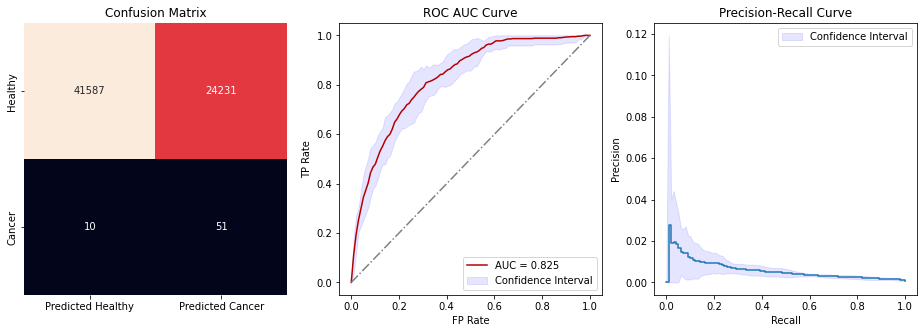



Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0          | 0           | 0          | 0          |
| recall__class_0    | 0          | 0           | 0          | 0          |
| f1-score__class_0  | 0          | 0           | 0          | 0          |
| precision__class_1 | 0.00195036 | 0.000342176 | 0.0014724  | 0.00256254 |
| recall__class_1    | 1          | 0           | 1          | 1          |
| f1-score__class_1  | 0.00389291 | 0.000681655 | 0.00294048 | 0.00511199 |
| accuracy           | 0.00195036 | 0.000342176 | 0.0014724  | 0.00256254 |
| auc                | 0.690698   | 0.0430946   | 0.61536    | 0.757645   |
+--------------------+------------+-------------+------------+------------+


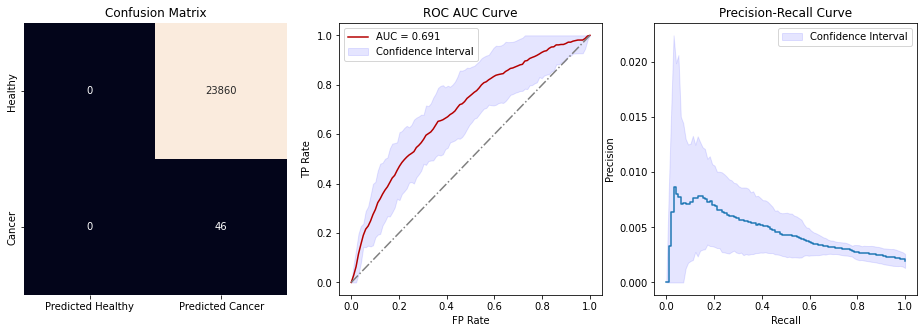



Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.99976   | 3.71609e-05 | 0.999674   | 0.999805  |
| recall__class_0    | 0.991142  | 0.00199596  | 0.988368   | 0.99362   |
| f1-score__class_0  | 0.995431  | 0.00100291  | 0.99404    | 0.996681  |
| precision__class_1 | 0.0133962 | 0.00482529  | 0.00550964 | 0.0194805 |
| recall__class_1    | 0.322282  | 0.0704849   | 0.2        | 0.428571  |
| f1-score__class_1  | 0.0256557 | 0.00904151  | 0.0107239  | 0.037037  |
| accuracy           | 0.990907  | 0.00198711  | 0.988153   | 0.993384  |
| auc                | 0.82909   | 0.0426504   | 0.75671    | 0.885496  |
+--------------------+-----------+-------------+------------+-----------+


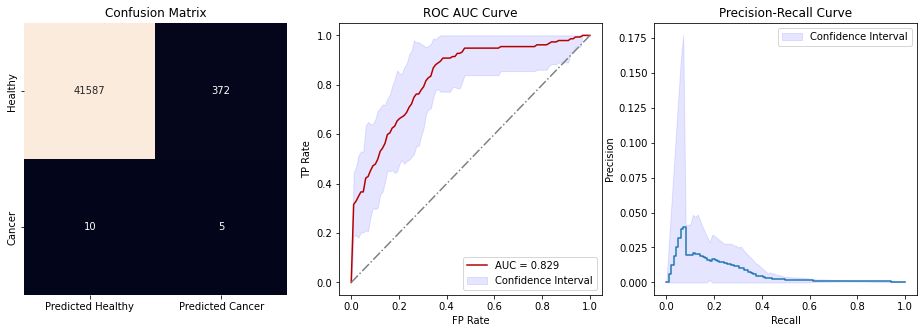

In [193]:
set_filter_display_report(cv_analytics_util, None)
set_filter_display_report(cv_analytics_util, mid_range_filter)
set_filter_display_report(cv_analytics_util, high_range_filter)
# set_filter_display_report(cv_analytics_util, positive_range_filter)

In [217]:
filesuffix = 'experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)


In [195]:
threshold = 0.183251076

In [196]:
cv_analytics_util.update_thresholds(threshold)



Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999231   | 0.000183949 | 0.998873   | 0.999402   |
| recall__class_0    | 0.946832   | 0.0066769   | 0.939158   | 0.956711   |
| f1-score__class_0  | 0.972314   | 0.00345497  | 0.968311   | 0.977382   |
| precision__class_1 | 0.00296634 | 0.00117415  | 0.00109709 | 0.00456026 |
| recall__class_1    | 0.17945    | 0.0663935   | 0.0571429  | 0.275862   |
| f1-score__class_1  | 0.00582852 | 0.00229303  | 0.00216802 | 0.00887199 |
| accuracy           | 0.946149   | 0.00654676  | 0.938583   | 0.955767   |
| auc                | 0.553885   | 0.070014    | 0.391568   | 0.6315     |
+--------------------+------------+-------------+------------+------------+


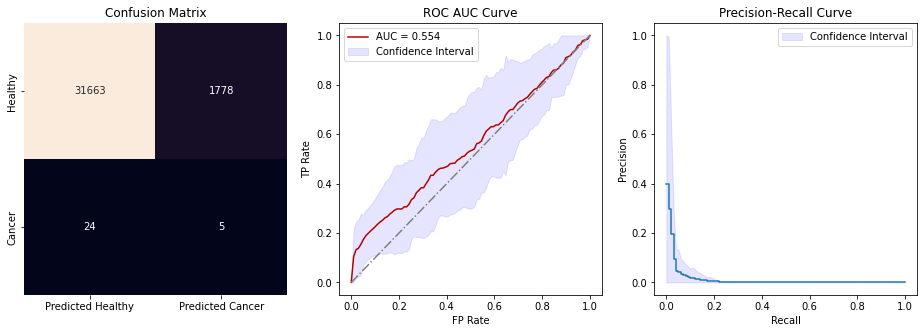



Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.998437   | 0.000439791 | 0.997763   | 0.999023   |
| recall__class_0    | 0.944158   | 0.0071391   | 0.933042   | 0.955616   |
| f1-score__class_0  | 0.970526   | 0.00368418  | 0.964568   | 0.976235   |
| precision__class_1 | 0.00613693 | 0.00256089  | 0.00192678 | 0.00998336 |
| recall__class_1    | 0.196077   | 0.0773106   | 0.0384615  | 0.285714   |
| f1-score__class_1  | 0.0118758  | 0.00492258  | 0.00366972 | 0.0191388  |
| accuracy           | 0.942782   | 0.00693453  | 0.931604   | 0.953578   |
| auc                | 0.563966   | 0.0704438   | 0.422811   | 0.65859    |
+--------------------+------------+-------------+------------+------------+


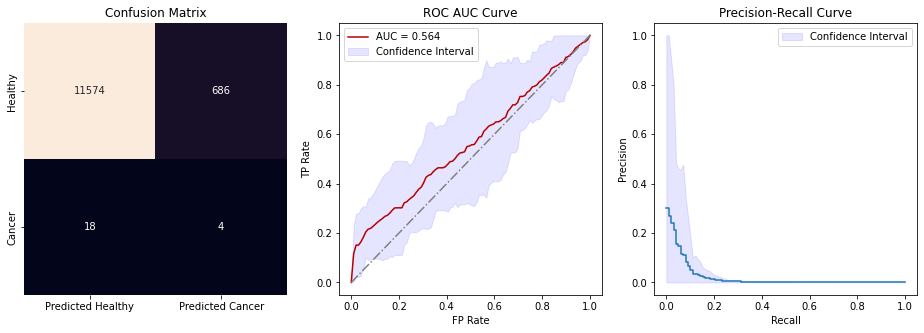



Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.99677   | 0.000714264 | 0.995645   | 0.997689  |
| recall__class_0    | 0.945049  | 0.00777618  | 0.935844   | 0.961148  |
| f1-score__class_0  | 0.970206  | 0.00407883  | 0.965526   | 0.9784    |
| precision__class_1 | 0.0168546 | 0.00608948  | 0.00377358 | 0.0228311 |
| recall__class_1    | 0.231455  | 0.0823409   | 0.0833333  | 0.357143  |
| f1-score__class_1  | 0.0313259 | 0.0112129   | 0.00722022 | 0.0421941 |
| accuracy           | 0.942217  | 0.00770316  | 0.933366   | 0.957738  |
| auc                | 0.596579  | 0.068994    | 0.522074   | 0.701279  |
+--------------------+-----------+-------------+------------+-----------+


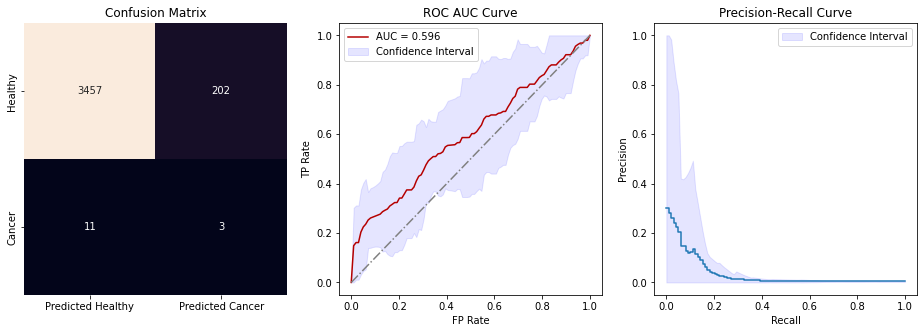

In [218]:
set_filter_display_report(cv_analytics_util, None)
set_filter_display_report(cv_analytics_util, mid_range_filter)
# set_filter_display_report(cv_analytics_util, high_range_filter)
set_filter_display_report(cv_analytics_util, positive_range_filter)

In [198]:
# filesuffix = 'experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials'
# cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)


In [199]:
# set_filter_display_report(cv_analytics_util, None)
# set_filter_display_report(cv_analytics_util, mid_range_filter)
# set_filter_display_report(cv_analytics_util, high_range_filter)
# set_filter_display_report(cv_analytics_util, positive_range_filter)

In [200]:
# thresholds = []
# for analytics_util in cv_analytics_util.analytics_utils:
#     thresholds.append(analytics_util.get_report_generation_util().get_roc_threshold())

In [201]:
full_df = []
for analytics_util in cv_analytics_util.analytics_utils:
    full_df.append(analytics_util.data_util.test_df)
full_df = pd.concat(full_df)
full_df = full_df[full_df[id_col].isin(all_mid_confidence_ids)].drop_duplicates()

In [202]:
# for analytics_util in cv_analytics_util.analytics_utils:
#     # analytics_util.data_util.test_df = full_df
#     analytics_util.data_util.test_df = analytics_util.data_util.test_df[analytics_util.data_util.test_df[id_col].isin(all_mid_confidence_ids)]
#     print(len(analytics_util.data_util.test_df))

In [203]:
# TODO: compare the confidences
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions_filtered(mid_range_filter) 
    X_test_mismatch = mid_range_filter(analytics_util.data_util.test_df).copy()[[id_col, 'plco_id', label]]
    # X_test_mismatch = mid_range_filter(analytics_util.data_util.test_df).copy()
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    id_and_confidence.append(X_test_mismatch)
    mid_conf_ids = X_test_mismatch[id_col].to_list()
mid_conf_predictions_2 = pd.concat(id_and_confidence)
confidence_comp = mid_conf_predictions_2.merge(mid_conf_predictions, on=[id_col, 'plco_id', label], how='left', suffixes=['_2', '_1']).dropna()

In [204]:
fn_on_first_try = confidence_comp[(confidence_comp['cancer_in_next_1_years'] == 1) & (confidence_comp['cancer_in_next_1_years_pred_1'] == 0)]
fn_on_second_try = confidence_comp[(confidence_comp['cancer_in_next_1_years'] == 1) & (confidence_comp['cancer_in_next_1_years_pred_2'] == 0)]

In [205]:
fn_on_second_try

,index,plco_id,cancer_in_next_1_years,cancer_in_next_1_years_pred_2,cancer_in_next_1_years_prob_2,age,cancer_in_next_1_years_pred_1,cancer_in_next_1_years_prob_1
1166,5746.0,A-038636-9,1.0,0,0.185735,65.0,1,0.619167
2082,10605.0,A-059741-1,1.0,0,0.136299,65.0,0,0.299150
2438,12555.0,A-067814-6,1.0,0,0.233112,65.0,0,0.232949
2497,12910.0,A-069164-3,1.0,0,0.010508,75.0,1,0.608669
3009,15172.0,A-077660-1,1.0,0,0.030597,70.0,1,0.709999
...,...,...,...,...,...,...,...,...
121502,651317.0,Z-133882-2,1.0,0,0.168239,75.0,0,0.487136
121695,652492.0,Z-138157-4,1.0,0,0.159991,65.0,0,0.463212
121788,653051.0,Z-139804-0,1.0,0,0.452461,60.0,0,0.381170
121964,654404.0,Z-146095-6,1.0,0,0.466892,75.0,0,0.208109


In [206]:
len(fn_on_first_try[fn_on_first_try['cancer_in_next_1_years_prob_2'] < fn_on_first_try['cancer_in_next_1_years_prob_1']])

64

In [207]:
len(fn_on_first_try[fn_on_first_try['cancer_in_next_1_years_prob_2'] < fn_on_first_try['cancer_in_next_1_years_prob_1'] + 0.1])

76

In [208]:
print_df(fn_on_first_try)

+--------+---------+------------+--------------------------+---------------------------------+---------------------------------+-------+---------------------------------+---------------------------------+
|        |   index | plco_id    |   cancer_in_next_1_years |   cancer_in_next_1_years_pred_2 |   cancer_in_next_1_years_prob_2 |   age |   cancer_in_next_1_years_pred_1 |   cancer_in_next_1_years_prob_1 |
|--------+---------+------------+--------------------------+---------------------------------+---------------------------------+-------+---------------------------------+---------------------------------|
|    182 |     892 | A-008936-9 |                        1 |                               1 |                      0.986036   |    70 |                               0 |                        0.450966 |
|   2082 |   10605 | A-059741-1 |                        1 |                               0 |                      0.136299   |    65 |                               0 |          

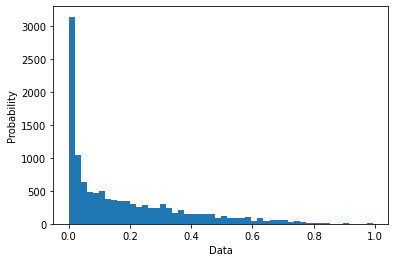

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(X_test_mismatch[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');



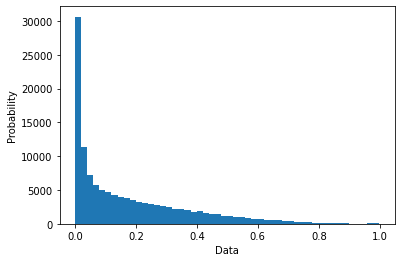

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(mid_conf_predictions_2[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');



In [211]:
# for filesuffix in experiment_names:
#     print(filesuffix)
#     load_cv_analytics_util_see_stats(filesuffix)